## Imports and Configuration

In [1]:
%load_ext autoreload
%autoreload 2

# this is so hacky but gets a sibling package imported if I decide to structure my projects this way.
import sys
import os
from pathlib import Path
parent = str(Path.cwd().parent)

if parent not in sys.path:
    sys.path.append(parent)

from src import visualizations as viz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from datetime import datetime

from scipy.io import arff
from scipy import stats

from sklearn import metrics

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.utils import resample, shuffle
#from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


%matplotlib inline
sns.set()
mpl.rcParams['figure.dpi'] = 100

ROOT_PATH = '../'
INPUT_PATH = ROOT_PATH + 'data/raw/'
INPUT_FILE = INPUT_PATH + 'ThoraricSurgery.arff'
INTERIM_PATH = ROOT_PATH + 'data/interim/'
INTERIM_FILE = INTERIM_PATH + 'thoracic.csv'
MODEL_PATH = ROOT_PATH + 'models/'

## Machine Learning

In [2]:
def thoracic_X_y(thoracic):
    cats_cols = ['Diagnosis', 'Performance', 'Tumour_Size']
    X = thoracic.drop(columns=['Risk1Yr'])
    X.loc[:, cats_cols] = X.loc[:, cats_cols].apply(LabelEncoder().fit_transform)
    y = thoracic.Risk1Yr
    
    return X, y

In [3]:
thoracic_final = pd.read_csv(INTERIM_FILE)
data = thoracic_final.copy()
train_df, test_df = train_test_split(data, test_size = 0.25, random_state = 42, stratify = data.Risk1Yr)

X_train, y_train = thoracic_X_y(train_df)
X_test, y_test = thoracic_X_y(test_df)

Testing the visualization imports

In [4]:
rf = RandomForestClassifier()
_ = rf.fit(X_train, y_train)

y_pr = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)
viz.evaluate_text(y_test, y_pr, y_prob)
#viz.plot_precision_and_roc(y_test, y_pr, y_prob)

accuracy = 0.833
precision = 0.000
recall = 0.000
AUC = 0.641


### Chi-Square Selection

I'm going to do this by hand although I know `scikit-learn` has functionality built in. I want to see the results though.

In [108]:
# remove numeric columns
chi_cols = set(thoracic_final.columns) - {'FVC', 'FEV1', 'Age', 'Risk1Yr'}
chi_p_values = dict()
for c in chi_cols:
    contingency_table = pd.crosstab(thoracic_final[c], thoracic_final.Risk1Yr)
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    chi_p_values[c] = p

# raised alpha slightly higher than 0.05 to caputre Cough as it is very close to our threshold and deserves to be included.
ALPHA = 0.05
chi_cols = [k for k, p in chi_p_values.items() if p <= ALPHA]

chi_df = (
    pd.DataFrame({'keys': list(chi_p_values.keys()),
                      'vals': list(chi_p_values.values())})
       .sort_values(by='vals')
       .set_index('keys'))
display(chi_df)
display(chi_df[chi_df.vals <= ALPHA])

,vals
keys,
Diagnosis,0.001453
Tumour_Size,0.002550
Type2Diabetes,0.031409
Dyspnoea,0.033945
Cough,0.065786
Weakness,0.107412
Performance,0.115131
Haemoptysis,0.120620
Smoking,0.131255


,vals
keys,
Diagnosis,0.001453
Tumour_Size,0.002550
Type2Diabetes,0.031409
Dyspnoea,0.033945


In [20]:
# an idea, but maybe not worth considering - never tested

# def build_pipe(num_cols, 
#                cat_cols,
#                nothing_cols=None,
#                label_encode=True,
#                ohe_drop=True):
    
#     def do_nothing(X): return X
    
#     num_transform = ('scale', StandardScaler(), num_cols)
    
#     if label_encode:
#         cat_transform = ('cat', HackedLabelEncoder(), cat_cols)
#     else:
#         if ohe_drop:
#             cat_transform = ('cat', OneHotEncoder(drop='first'), cat_cols)
#         else:
#             cat_transform = ('cat', OneHotEncoder(), cat_cols)
#     if nothing_cols:
#         nothing_transform = ('nothing', FunctionTransformer(do_nothing), nothing_cols)
#         pipe = ColumnTransformer([
#             num_transform,
#             cat_transform,
#             nothing_transform
#         ])
#     else:
#         pipe = ColumnTransformer([
#             num_transform,
#             cat_transform,
#             nothing_transform
#         ], remainder='passthrough')
#     return pipe

`LabelEncoder` didn't work correctly with PipeLine so I rolled my own LabelEncoder.

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class HackedLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._label_encoders = {}
        pass
        
    def fit(self, X, y=None):
        for c in X.columns:
            le = LabelEncoder()
            le.fit(X[c])
            self._label_encoders[c] = le
        return self
    
    def transform(self, X, y=None):
        for c in X.columns:
            X.loc[:, c] = self._label_encoders[c].transform(X[c])
        return X
    
    def get_label_encoders(self):
        return self._label_encoders

In [109]:
# useful because I don't want to do anything to a number of columns,
#    but I want to drop columns not defined. ColumnTransformer will
#    drop columns not acted upon unless you define passthrough
def do_nothing(X):
    return X

num_cols = ['FVC', 'FEV1', 'Age']
cat_cols = ['Diagnosis', 'Performance', 'Tumour_Size']
cat_cols_chi = ['Diagnosis', 'Tumour_Size']
selected_features = chi_cols + num_cols
nothing_cols = [c for c in selected_features if c not in num_cols + cat_cols_chi]

# for random forest we will label encode rather than one hot encode
full_pipe_le = ColumnTransformer([
    ('scale', StandardScaler(), num_cols),
    ('cat', HackedLabelEncoder(), cat_cols),
], remainder = 'passthrough')

full_pipe = ColumnTransformer([
    ('scale', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols), # cannot drop first with a NN
], remainder = 'passthrough')

# apply the nothing function to the nothing cols
chi_pipe_le = ColumnTransformer([
    ('scale', StandardScaler(), num_cols),
    ('cat', HackedLabelEncoder(), cat_cols_chi),
    ('nothing', FunctionTransformer(do_nothing), nothing_cols),
])

chi_pipe = ColumnTransformer([
    ('scale', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols_chi), # cannot drop first with a NN
    ('nothing', FunctionTransformer(do_nothing), nothing_cols),
])

# now lets create lists of columns names to be able to convert these into pretty dataframes
full_pipe_cols = (num_cols + cat_cols + 
                     [col for col in X_train.columns 
                      if col not in num_cols + cat_cols])
chi_pipe_cols = (num_cols + cat_cols_chi + nothing_cols)

pipelines_le = [full_pipe_le, chi_pipe_le]
pipelines_ohe = [full_pipe, chi_pipe]
columns_lists = [full_pipe_cols, chi_pipe_cols]

#### Dispatcher

In [82]:
dispatcher = {
    'randomforest': {
        'clf': RandomForestClassifier(),
        'param_grid': {
            'class_weight': ['balanced_subsample'],
            'n_estimators': [10, 20, 50, 100, 200],
            'max_depth': [None, 4, 8, 16],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'max_features': ['auto', None]
        },
        'param_dist': {},
    },
    
    'logistic': {
        'clf': LogisticRegression(C = 1, class_weight='balanced', max_iter=1000),
        'param_grid': {},
        'param_dist': {
            'C': stats.reciprocal(a = 1e-6, b = 1e2),
        },
    },
    
    'svc': {
        'clf': SVC(gamma = 5, 
                   C = 0.001, 
                   probability = True,
                   class_weight='balanced'),
        'param_grid': {},
        'param_dist': {
            'gamma': stats.reciprocal(a=1e-7, b = 1e2),
            'C': stats.reciprocal(a = 1e-4, b = 1e4),
        },
    }
}

#### GridSearch and Randomized Search Functions

In [45]:
def my_grid_search_cv(model, 
                      pipelines,
                      X,
                      y,
                      cv,
                      metric='precision'):
    gs_results = []
    for p in pipelines:
        data = p.fit_transform(X)
        gs = GridSearchCV(estimator = dispatcher[MODEL]['clf'],
                          param_grid = dispatcher[MODEL]['param_grid'],
                          cv = skf,
                          scoring = 'precision',
                          n_jobs = -1,
                          return_train_score=True,
                          verbose=1)
        gs.fit(data, y)
        gs_results.append(gs)
    return gs_results


def my_randomized_search_cv(model, 
                            pipelines,
                            X,
                            y,
                            cv,
                            metric='precision',
                            n_iter=1000):
    rs_results = []
    for p in pipelines:
        data = p.fit_transform(X)
        rs = RandomizedSearchCV(
            estimator=dispatcher[model]['clf'],
            param_distributions=dispatcher[model]['param_dist'],
            n_iter=n_iter,
            cv=cv,
            scoring=metric,
            n_jobs=-1,
            return_train_score=True,
            verbose=1)
        rs.fit(data, y)
        rs_results.append(rs)
    return rs_results

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)
MODEL = 'randomforest'
model_file = MODEL_PATH + f'grid_search_{MODEL}_both.pkl'
pipe_files = [
    MODEL_PATH + f'pipeline_full_le.pkl',
    MODEL_PATH + f'pipeline_chi_le.pkl'
]
    

reload = False
if os.path.exists(model_file) and reload:
    print(f'reloading {model_file}')
    gs_rf = pickle.load(open(model_file, "rb" ))
    pipelines_le = [pickle.load(open(f, "rb" )) for f in pipe_files]
else:
    print('building new grid search')
    gs_rf = my_grid_search_cv(MODEL, 
                              pipelines_le,
                              X_train,
                              y_train,
                              skf,
                              'precision')
    for p, f in zip(pipelines_le, pipe_files):
        pickle.dump( p, open(f, "wb" ) )

reloading ../models/grid_search_randomforest_both.pkl


In [26]:
print(gs_rf[0].best_params_)
print(gs_rf[1].best_params_)

{'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}
{'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100}


In [27]:
clf = gs_rf[0].best_estimator_
description = "Random Forest - Full"
viz.evaluate_model(clf, X_test, y_test, description=description, plot=False)

Random Forest - Full
accuracy = 0.851
precision = 0.000
recall = 0.000
AUC = 0.631


/home/mark/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
clf = gs_rf[1].best_estimator_
pipe = pipelines_le[1]
test_data = pipe.transform(X_test)
viz.evaluate_model(clf, test_data, y_test, "Random Forest - Chi", plot=False)

Random Forest - Chi
accuracy = 0.825
precision = 0.200
recall = 0.059
AUC = 0.573


#### RandomizedSearchCV SVC

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)
MODEL = 'svc'
model_file = MODEL_PATH + f'random_search_{MODEL}_both.pkl'
pipe_files = [
    MODEL_PATH + f'pipeline_full_ohe.pkl',
    MODEL_PATH + f'pipeline_chi_ohe.pkl'
]
    

reload = True
if os.path.exists(model_file) and reload:
    print(f'reloading {model_file}')
    rs_svc = pickle.load(open(model_file, "rb" ))
    pipelines_ohe = [pickle.load(open(f, "rb" )) for f in pipe_files]
else:
    print('building new grid search')
    rs_svc = my_randomized_search_cv(MODEL, 
                                     pipelines_ohe,
                                     X_train,
                                     y_train,
                                     skf,
                                     'precision',
                                    n_iter = 1000)
    for p, f in zip(pipelines_ohe, pipe_files):
        pickle.dump( p, open(f, "wb" ) )

building new grid search
(340, 24)
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   40.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(340, 15)
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   39.3s finished


In [40]:
print(rs_svc[0].best_params_)
print(rs_svc[1].best_params_)

{'C': 879.3655563786422, 'gamma': 4.636775252954661e-05}
{'C': 0.4415489762255517, 'gamma': 4.981708611804625}


In [41]:
X_test.shape, pipe.transform(X_test).shape

((114, 16), (114, 24))

In [42]:
clf = rs_svc[0].best_estimator_
pipe = pipelines_ohe[0]
test_data = pipe.transform(X_test)
viz.evaluate_model(clf, test_data, y_test, 'SVC - Full', plot=False)

SVC - Full
accuracy = 0.342
precision = 0.163
recall = 0.824
AUC = 0.630


In [43]:
clf = rs_svc[1].best_estimator_
pipe = pipelines_ohe[1]
test_data = pipe.transform(X_test)
viz.evaluate_model(clf, test_data, y_test, 'SVC - Chi', plot=False)

SVC - Chi
accuracy = 0.816
precision = 0.000
recall = 0.000
AUC = 0.625


### XGBoost

This will be the first stab at doing an XGBoost on this dataset.

In [32]:
xgb = XGBClassifier()

In [134]:
# Create Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the DMatrix from X and y: churn_dmatrix
X = pipelines_le[0].transform(X_train)
thoracic_dmatrix = xgb.DMatrix(data=X, label=y_train)
params = {"objective": "binary:logistic", 
          "max_depth": 6, 
          "lambda": 0.1,
          "eta": .03,
          #"colsample_bytree": 0.7,
          #"subsample": 0.8
         }

# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=thoracic_dmatrix,
                    params=params,
                    nfold=5,
                    folds=skf,
                    num_boost_round=500,
                        metrics={"logloss", "error", "auc"},
                    as_pandas=True,
                    seed=42,
                    callbacks=[#xgb.callback.print_evaluation(show_stdv=True),
                               xgb.callback.early_stop(10),]
                   )
display(cv_results)

Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[15]	train-auc:0.94504+0.01443	train-logloss:0.48622+0.00431	train-error:0.11176+0.01176	test-auc:0.56706+0.12390	test-logloss:0.54272+0.01556	test-error:0.17353+0.02353



,train-auc-mean,train-auc-std,train-logloss-mean,train-logloss-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-logloss-mean,test-logloss-std,test-error-mean,test-error-std
0,0.856875,0.024612,0.674433,0.001110,0.122794,0.014816,0.541768,0.123029,0.679158,0.002676,0.223529,0.044991
1,0.881112,0.033969,0.656938,0.001480,0.116177,0.009755,0.549065,0.128546,0.665344,0.003711,0.179412,0.017150
2,0.878155,0.033723,0.640477,0.002103,0.118382,0.011719,0.551169,0.133039,0.652296,0.005223,0.182353,0.017647
3,0.885560,0.027767,0.625282,0.002365,0.119118,0.010294,0.545725,0.136903,0.640194,0.006177,0.182353,0.017647
4,0.899809,0.025819,0.610607,0.002361,0.116912,0.009125,0.562509,0.146470,0.629305,0.007396,0.182353,0.017647
5,0.910147,0.025970,0.596626,0.002710,0.116177,0.009474,0.564617,0.125552,0.618302,0.008155,0.176471,0.022782
6,0.919157,0.015091,0.583246,0.002512,0.116912,0.007851,0.572346,0.121043,0.608987,0.009655,0.176471,0.022782
7,0.926359,0.013110,0.570454,0.002429,0.117647,0.009865,0.575872,0.118334,0.599469,0.009825,0.179412,0.021613
8,0.932060,0.013425,0.558109,0.002149,0.117647,0.011151,0.583687,0.113953,0.590766,0.009738,0.176471,0.022782
9,0.934287,0.012656,0.546273,0.002501,0.114706,0.010756,0.576135,0.121493,0.582604,0.011286,0.176471,0.022782


In [122]:
# Create Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the DMatrix from X and y: churn_dmatrix
X = pipelines_le[0].transform(X_train)
thoracic_dmatrix = xgb.DMatrix(data=X, label=y_train)

param_dist = {
    #"objective": "binary:logistic", 
    "gamma": np.arange(0, 2, 0.1),
    "max_depth": [2, 4, 6, 8, 12, 16, 20], 
    "learning_rate": np.arange(0.001, 1.001, 0.001),
    "subsample": np.arange(0.05, 1.05, 0.05),
    "colsample_bytree": np.arange(0.05, 1.05, 0.05),
    "n_estimators": np.arange(10, 510, 10)
    #"colsample_bytree": 0.7,
          #"subsample": 0.8
         }


# Perform cross_validation: cv_results
rs = RandomizedSearchCV(
            estimator=xgb.XGBClassifier(),
            param_distributions=param_dist,
            n_iter=500,
            cv=skf,
            scoring='roc_auc',
            n_jobs=-1,
            return_train_score=True,
            verbose=2)
_ = rs.fit(X, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   38.7s finished


In [123]:
print(rs.best_score_)
print(rs.best_params_)

0.6998748831325964
{'subsample': 0.4, 'n_estimators': 20, 'max_depth': 12, 'learning_rate': 0.419, 'gamma': 1.5, 'colsample_bytree': 0.9000000000000001}


In [124]:
rs.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9000000000000001,
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.419,
              max_delta_step=0, max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method=None, validate_parameters=False, verbosity=None)

In [131]:
y_prob = clf.predict_proba(test_data)
metrics.roc_auc_score(y_test, y_prob[:, 1], average='weighted')

0.5081867798665858

In [132]:
np.column_stack((y_test, y_prob[:, 1]))

array([[0.        , 0.07823605],
       [0.        , 0.04264751],
       [0.        , 0.31505215],
       [0.        , 0.04981392],
       [0.        , 0.47065952],
       [0.        , 0.20147507],
       [0.        , 0.15834501],
       [0.        , 0.05548046],
       [0.        , 0.03997241],
       [0.        , 0.0563644 ],
       [0.        , 0.05395722],
       [1.        , 0.29495654],
       [0.        , 0.05859446],
       [0.        , 0.16070668],
       [0.        , 0.34399971],
       [0.        , 0.03558878],
       [0.        , 0.04062745],
       [1.        , 0.45246175],
       [1.        , 0.11270914],
       [0.        , 0.01755891],
       [0.        , 0.07811356],
       [0.        , 0.2603215 ],
       [0.        , 0.07308453],
       [0.        , 0.0664184 ],
       [0.        , 0.09636452],
       [1.        , 0.1008826 ],
       [0.        , 0.09285279],
       [0.        , 0.17564523],
       [1.        , 0.03050568],
       [0.        , 0.04353447],
       [1.

XGBosst - Full
accuracy = 0.842
precision = 0.333
recall = 0.059
AUC = 0.508


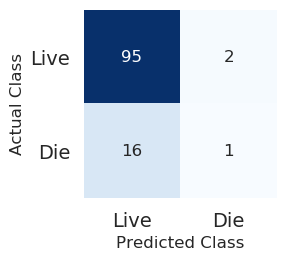

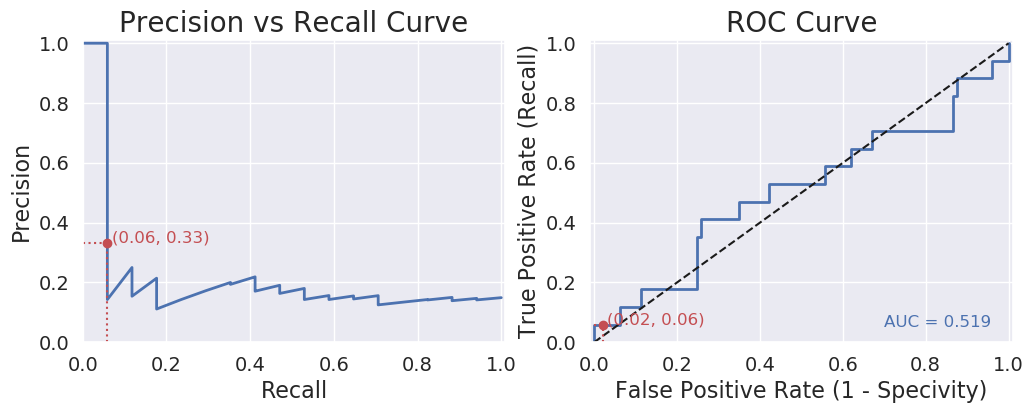

In [130]:
clf = rs.best_estimator_.fit(X, y_train)
pipe = pipelines_le[0]
test_data = pipe.transform(X_test)
viz.evaluate_model(clf, test_data, y_test, 'XGBosst - Full', plot=True)

In [112]:
# Create Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the DMatrix from X and y: churn_dmatrix
X = pipelines_ohe[0].transform(X_train)
thoracic_dmatrix = xgb.DMatrix(data=X, label=y_train)

param_dist = {
    #"objective": "binary:logistic", 
    "gamma": np.arange(0, 2, 0.1),
    "max_depth": [2, 4, 6, 8, 12, 16, 20], 
    "learning_rate": np.arange(0.001, 1.001, 0.001),
    "subsample": np.arange(0.05, 1.05, 0.05),
    "colsample_bytree": np.arange(0.05, 1.05, 0.05),
    "n_estimators": np.arange(10, 510, 10)
    #"colsample_bytree": 0.7,
          #"subsample": 0.8
         }


# Perform cross_validation: cv_results
rs = RandomizedSearchCV(
            estimator=xgb.XGBClassifier(),
            param_distributions=param_dist,
            n_iter=500,
            cv=skf,
            scoring='roc_auc',
            n_jobs=-1,
            return_train_score=True,
            verbose=2)
_ = rs.fit(X, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1332 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   46.8s finished


In [113]:
print(rs.best_score_)
print(rs.best_params_)

0.6823582467139635
{'subsample': 0.25, 'n_estimators': 90, 'max_depth': 20, 'learning_rate': 0.78, 'gamma': 1.6, 'colsample_bytree': 0.9500000000000001}


XGBosst - Full
accuracy = 0.728
precision = 0.150
recall = 0.176
AUC = 0.501


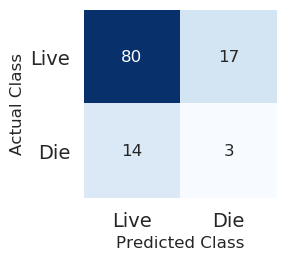

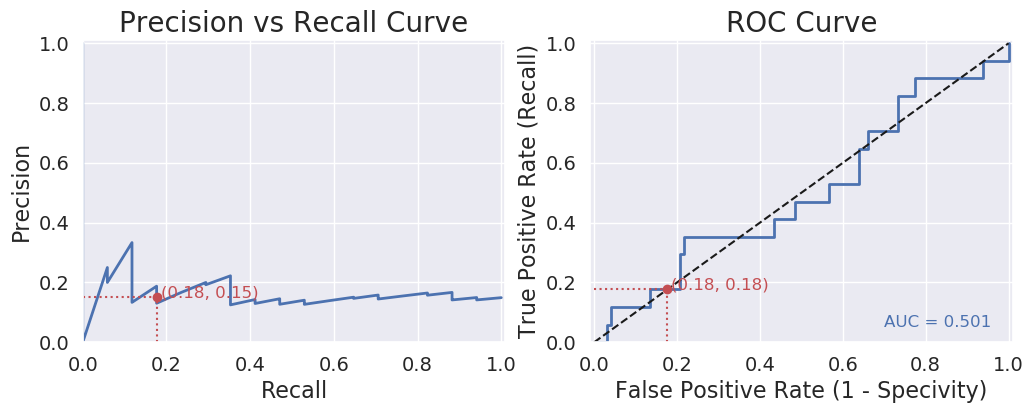

In [114]:
clf = rs.best_estimator_
pipe = pipelines_ohe[0]
test_data = pipe.transform(X_test)
viz.evaluate_model(clf, test_data, y_test, 'XGBosst - Full', plot=True)

In [108]:
X

array([[-0.3798968 , -0.66971349, -0.42319792, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10801837,  0.38972886,  0.65326562, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.16074765,  0.26052858,  1.72972916, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.70761693,  0.72564961,  0.89247974, ...,  0.        ,
         0.        ,  0.        ],
       [-0.3798968 , -0.10123222, -0.30359086, ...,  0.        ,
         1.        ,  0.        ],
       [-1.01427981, -0.46299303,  0.77287268, ...,  0.        ,
         1.        ,  0.        ]])

In [39]:
for tr, te in skf.split(X_train, y_train):
    print(te)

[  0   3   5   6  12  16  17  19  52  53  54  67  72  77  80  81  83  87
  88 100 108 111 112 116 122 142 156 159 173 174 175 179 183 184 188 192
 200 201 207 211 214 216 233 237 241 246 250 252 259 260 266 267 269 270
 272 277 281 283 292 294 296 300 307 308 314 317 324 334]
[  8  20  23  27  28  30  34  35  36  37  62  68  69  70  71  79  84  85
  86  92  93  96  99 102 105 117 125 132 138 143 144 145 151 153 155 161
 167 169 171 180 194 199 202 223 230 232 243 245 253 255 268 274 276 279
 287 288 289 290 293 297 298 302 313 328 329 336 337 339]
[  1   7  13  26  32  33  39  43  45  47  48  50  51  55  56  57  58  64
  74  75  94 109 113 115 134 136 146 147 148 149 154 160 162 163 165 172
 176 178 187 190 203 212 215 218 222 224 226 227 235 236 238 240 258 262
 271 275 278 284 291 299 301 304 312 318 322 323 327 331]
[  4   9  10  11  18  21  24  38  41  42  46  61  63  65  73  82  89  95
  97  98 103 107 110 114 123 126 128 129 135 137 150 158 164 166 168 170
 177 182 186 191 197 20

## SMOTE

Synthetic Minority Oversampling Technique.

Original paper: **add link** N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 16, 321-357, 2002.

Although I am not finished with XGBoost yet, and I still have a lot to review the initial results are not promising. It's certainly time to explore sampling techniques.

In [49]:
from imblearn.over_sampling import SMOTENC

In [87]:
thoracic_final = pd.read_csv(INTERIM_FILE)
data = thoracic_final.copy()
train_df, test_df = train_test_split(data, test_size = 0.20, random_state = 642, stratify = data.Risk1Yr)

X_train, y_train = thoracic_X_y(train_df)
X_test, y_test = thoracic_X_y(test_df)

In [120]:
chi_pipe_cols

['FVC', 'FEV1', 'Age', 'Diagnosis', 'Tumour_Size', 'Type2Diabetes', 'Dyspnoea']

In [106]:
X_train

,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumour_Size,Type2Diabetes,MI,PAD,Smoking,Asthma,Age
350,2,2.20,1.60,1,0,1,0,1,0,1,0,0,0,1,0,59.0
131,1,3.76,3.08,1,0,0,0,1,0,2,0,0,0,1,0,54.0
18,2,2.60,1.68,1,0,0,0,1,0,1,0,0,0,1,0,70.0
413,2,3.44,2.72,1,1,1,0,1,0,0,0,0,0,0,0,73.0
67,2,2.72,2.20,1,0,0,0,1,0,1,0,0,0,1,0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2,2.96,2.44,1,0,0,0,1,1,0,0,0,0,1,0,60.0
87,4,2.68,1.76,2,0,1,0,1,1,0,0,0,0,1,0,76.0
227,2,2.60,2.00,1,0,0,0,1,0,1,0,0,0,1,0,58.0
168,2,2.60,2.36,1,0,0,0,1,0,0,0,0,0,1,0,55.0


In [117]:
X_scaled = chi_pipe_le.fit_transform(X_train)
cat_indices = [X_train.columns.get_loc(c) for c in X_train.columns if 
               c not in num_cols]

In [119]:
X_scaled[0,:]

array([-1.23999703, -1.20766841, -0.48266471,  2.        ,  1.        ,
        0.        ,  0.        ])

In [121]:
smote_nc = SMOTENC(categorical_features=[3, 4, 5, 6], random_state=42)

In [122]:
X_resampled, y_resampled = smote_nc.fit_resample(X_scaled, y_train)

In [123]:
X_train.shape, X_resampled.shape

((363, 16), (616, 7))

In [124]:
y_train.value_counts(), y_resampled.value_counts()

(0    308
 1     55
 Name: Risk1Yr, dtype: int64,
 1    308
 0    308
 Name: Risk1Yr, dtype: int64)

In [125]:
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
rf = RandomForestClassifier()
results = cross_val_score(rf, X_resampled, y_resampled, 
                cv=skf, scoring="roc_auc", n_jobs=-1)
results

array([0.93444329, 0.94640999, 0.93288241, 0.86628512, 0.91675338,
       0.93704475, 0.87634409, 0.9188172 , 0.92956989, 0.94301075])

In [126]:
MODEL = 'randomforest'
gs = GridSearchCV(estimator = dispatcher[MODEL]['clf'],
                  param_grid = dispatcher[MODEL]['param_grid'],
                  cv = skf,
                  scoring = 'precision',
                  n_jobs = -1,
                  return_train_score=True,
                  verbose=1)
_ = gs.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2393 out of 2400 | elapsed:  1.9min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  1.9min finished


Random Forest - Full - SMOTE
accuracy = 0.997
precision = 1.000
recall = 0.994
AUC = 1.000


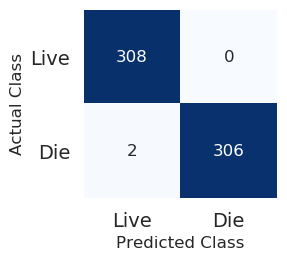

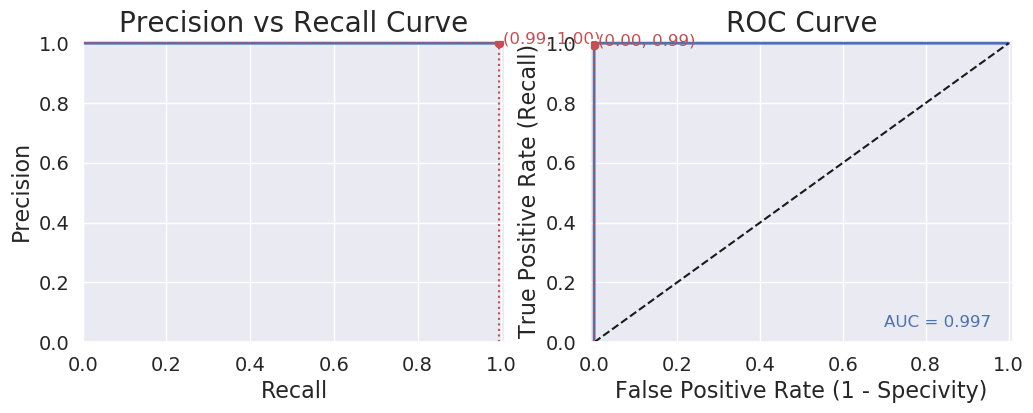

In [127]:
clf = gs.best_estimator_
description = "Random Forest - Full - SMOTE"
viz.evaluate_model(clf, X_resampled, y_resampled, description=description, plot=True)

In [134]:
proba = gs.best_estimator_.predict_proba(chi_pipe_le.transform(X_test))
np.column_stack((y_test, proba[:, 1]))

array([[0.  , 0.2 ],
       [0.  , 0.75],
       [0.  , 0.  ],
       [0.  , 0.4 ],
       [0.  , 0.3 ],
       [1.  , 0.5 ],
       [0.  , 0.65],
       [0.  , 0.25],
       [0.  , 0.1 ],
       [0.  , 0.  ],
       [0.  , 0.3 ],
       [0.  , 0.5 ],
       [0.  , 0.1 ],
       [1.  , 0.5 ],
       [1.  , 0.2 ],
       [0.  , 0.3 ],
       [0.  , 0.35],
       [0.  , 0.4 ],
       [1.  , 0.  ],
       [0.  , 0.05],
       [0.  , 0.9 ],
       [1.  , 0.55],
       [0.  , 0.  ],
       [0.  , 0.25],
       [1.  , 0.45],
       [0.  , 0.45],
       [0.  , 0.45],
       [0.  , 0.  ],
       [0.  , 0.05],
       [0.  , 0.  ],
       [1.  , 0.1 ],
       [0.  , 0.8 ],
       [0.  , 0.15],
       [0.  , 0.3 ],
       [0.  , 0.85],
       [0.  , 0.25],
       [1.  , 0.3 ],
       [0.  , 0.25],
       [0.  , 0.6 ],
       [0.  , 0.4 ],
       [0.  , 0.45],
       [0.  , 0.  ],
       [0.  , 0.45],
       [0.  , 0.15],
       [0.  , 0.55],
       [0.  , 0.2 ],
       [0.  , 0.45],
       [0.  ,

Random Forest - Full - SMOTE
accuracy = 0.692
precision = 0.182
recall = 0.286
AUC = 0.525


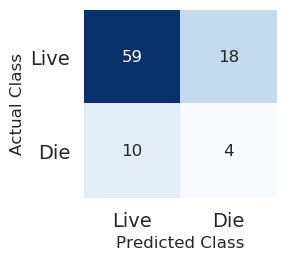

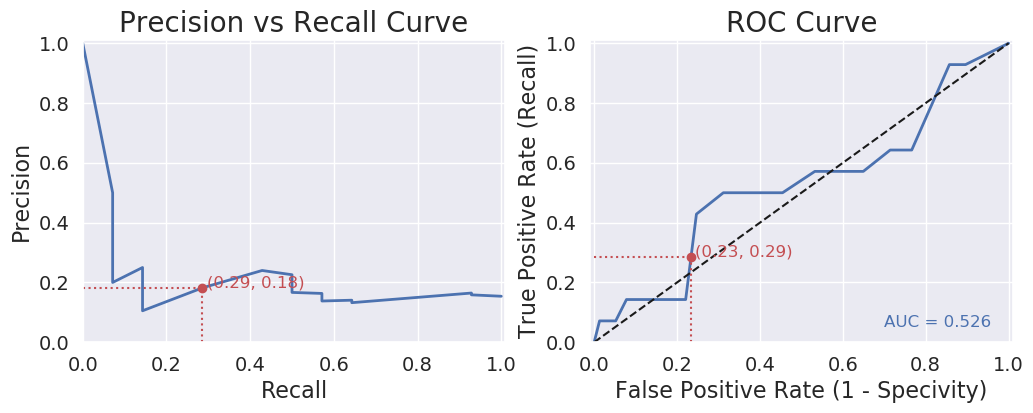

In [130]:
clf = gs.best_estimator_
description = "Random Forest - Full - SMOTE"
viz.evaluate_model(clf, chi_pipe_le.transform(X_test), y_test, description=description, plot=True)

In [101]:
MODEL = 'logistic'
rs = RandomizedSearchCV(estimator=dispatcher[MODEL]['clf'],
                   param_distributions=dispatcher[MODEL]['param_dist'],
                   n_iter=100,
                   cv=skf,
                   scoring='precision',
                   n_jobs=-1,
                   return_train_score=True,
                   verbose=1)
_ = rs.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.3s finished


In [102]:
clf = rs.best_estimator_
description = "Logistic Regression - Full - SMOTE"
viz.evaluate_model(clf, X_resampled, y_resampled, description=description, plot=False)

Logistic Regression - Full - SMOTE
accuracy = 0.722
precision = 0.673
recall = 0.864
AUC = 0.788


In [103]:
y_test.value_counts()

0    77
1    14
Name: Risk1Yr, dtype: int64

Logistic Regression - Full - SMOTE
accuracy = 0.593
precision = 0.129
recall = 0.286
AUC = 0.449


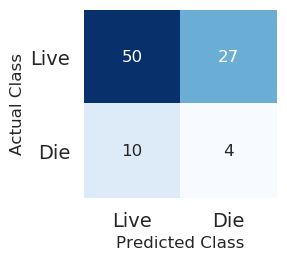

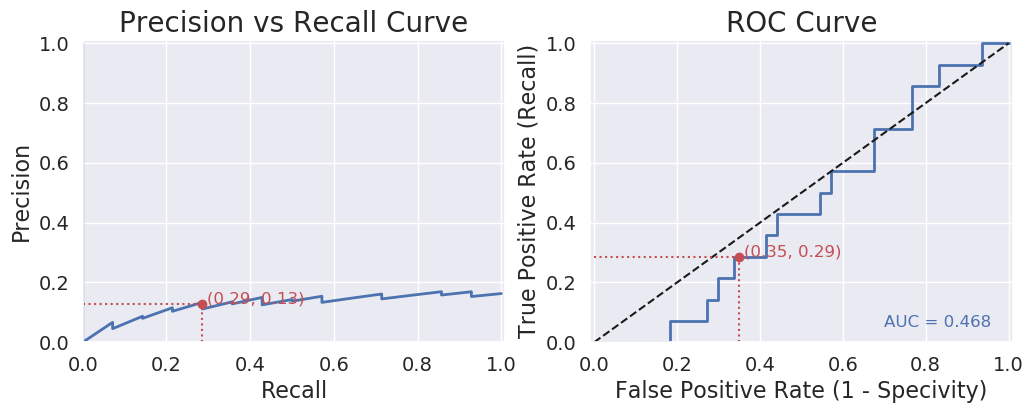

In [104]:
clf = rs.best_estimator_
description = "Logistic Regression - Full - SMOTE"
viz.evaluate_model(clf, X_test, y_test, description=description, plot=True)

In [154]:
rf.fit(X_train['Tumour_Size'].values.reshape(-1, 1), y_train)
p = rf.predict(X_test['Tumour_Size'].values.reshape(-1, 1))
r = np.column_stack((y_test, p))
(r[:, 0] == r[:, 1]).mean()

0.8131868131868132

In [155]:
r

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0,

In [145]:
X_train['Tumour_Size'].values.reshape(-1,1).shape

(363, 1)